# Regresión de Poisson en Python — Crime and Punishment (cpunish)
**Duración:** ~30 minutos  
**Objetivo:** Ajustar e interpretar una regresión de Poisson para datos de conteo (número de ejecuciones).

### Objetivos de aprendizaje
- Reconocer los **resultados de tipo conteo** y comprender por qué la regresión lineal no es apropiada en estos casos.  
- Ajustar un **modelo lineal generalizado de Poisson (GLM con enlace logarítmico)** utilizando `statsmodels`.  
- Interpretar los coeficientes en términos de **efectos multiplicativos** (mediante la exponenciación).  
- Verificar la **sobredispersión** básica y comparar con un modelo **binomial negativo**.


## ¿Qué es una distribución de Poisson?

La **distribución de Poisson** modela el **número de eventos** que ocurren en un intervalo fijo de tiempo o espacio, bajo estas condiciones:
- Los eventos ocurren **independientemente** entre sí.
- La **tasa media** de ocurrencia por unidad (λ, “lambda”) es **constante**.
- La probabilidad de más de un evento en un intervalo muy pequeño es despreciable.

**Función de probabilidad (pmf):**
$
P(X = k) \;=\; \frac{e^{-\lambda}\,\lambda^{k}}{k!}, \quad k = 0,1,2,\dots
$

**Propiedades clave:**
- **Media:** $E[X] = \lambda$
- **Varianza:** $Var(X) = \lambda$
- Soporta datos de **conteo** (enteros no negativos).

**Procesos que modela:**
- Llegadas de clientes a una cola (por minuto).
- Número de llamadas a un call center por hora.
- Conteo de defectos en una longitud de material.
- Casos de un suceso raro por unidad (p. ej., mutaciones por Mb).

> En un **proceso de Poisson** con tasa $\lambda$, el número de eventos en cualquier intervalo de longitud $t$ sigue $\text{Poisson}\lambda_t$.

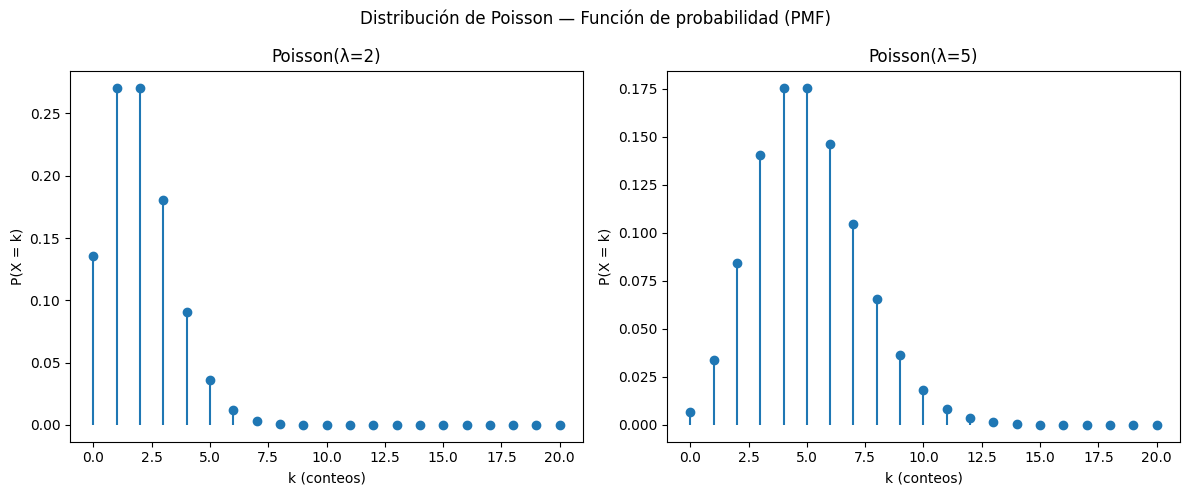

In [14]:
# Visualización de la distribución de Poisson (PMF) para distintos λ
from scipy.stats import poisson

# Parámetros (puedes cambiarlos)
lambdas = [2, 5]     # tasas medias (λ)
k = np.arange(0, 21) # soporte discreto: 0..20

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, lam in enumerate(lambdas):
    pmf = poisson.pmf(k, mu=lam)
    axes[i].stem(k, pmf, basefmt=" ")
    axes[i].set_xlabel("k (conteos)")
    axes[i].set_ylabel("P(X = k)")
    axes[i].set_title(f"Poisson(λ={lam})")

plt.suptitle("Distribución de Poisson — Función de probabilidad (PMF)")
plt.tight_layout()
plt.show()

In [15]:

# Setup
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)



## 1) Carga e inspección de datos

El conjunto de datos **Crime and Punishment (`cpunish`)** proviene de `statsmodels` y contiene información socioeconómica y demográfica de los estados de EE. UU., junto con datos sobre la aplicación de la pena de muerte.  

Se utiliza comúnmente para ilustrar modelos de regresión de conteo, como la **regresión de Poisson** o **binomial negativa**, donde la variable dependiente es el número de ejecuciones.

| Variable | Tipo | Descripción |
|-----------|------|-------------|
| **EXECUTIONS** | `float64` | Número de ejecuciones (pena de muerte) en el estado entre 1977 y 1996. Es la variable dependiente del modelo. |
| **INCOME** | `float64` | Ingreso personal promedio per cápita del estado (en miles de dólares). |
| **PERPOVERTY** | `float64` | Porcentaje de la población del estado que vive por debajo del umbral de pobreza. |
| **PERBLACK** | `float64` | Porcentaje de la población afroamericana en el estado. |
| **VC100k96** | `float64` | Tasa de crímenes violentos en 1996 por cada 100 000 habitantes. |
| **SOUTH** | `float64` | Variable indicadora (dummy): 1 si el estado pertenece al sur de EE. UU., 0 en caso contrario. |
| **DEGREE** | `float64` | Porcentaje de la población adulta con al menos un título universitario. |

### 🧠 Contexto
Este conjunto permite explorar cómo los factores socioeconómicos y demográficos se relacionan con la frecuencia de ejecuciones.  
Por ejemplo, una **regresión de Poisson** puede estimar cómo varía el número esperado de ejecuciones según el nivel de ingreso, la educación o la ubicación geográfica del estado.

In [16]:

data = sm.datasets.cpunish.load_pandas().data
data.head()


,EXECUTIONS,INCOME,PERPOVERTY,PERBLACK,VC100k96,SOUTH,DEGREE
0,37.0,34453.0,16.7,12.2,644.0,1.0,0.16
1,9.0,41534.0,12.5,20.0,351.0,1.0,0.27
2,6.0,35802.0,10.6,11.2,591.0,0.0,0.21
3,4.0,26954.0,18.4,16.1,524.0,1.0,0.16
4,3.0,31468.0,14.8,25.9,565.0,1.0,0.19


In [17]:

# Estructura básica y tipos de datos
print(data.shape)
print(data.dtypes)
data['EXECUTIONS'].describe()


(17, 7)
EXECUTIONS    float64
INCOME        float64
PERPOVERTY    float64
PERBLACK      float64
VC100k96      float64
SOUTH         float64
DEGREE        float64
dtype: object


count    17.000000
mean      4.352941
std       8.695841
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max      37.000000
Name: EXECUTIONS, dtype: float64


## 2) Ajuste de una regresión de tipo Poisson
Predeciremos `executions` a partir de algunos predictores simples: `INCOME`, `SOUTH`, `PERBLACK`, `DEGREE`.  
Enlace: **logarítmico** (**log**).


In [23]:
X = data[["INCOME", "SOUTH", "PERBLACK", "DEGREE"]].copy()
y = data["EXECUTIONS"].astype(int)

X = sm.add_constant(X)
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
poisson_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             EXECUTIONS   No. Observations:                   17
Model:                            GLM   Df Residuals:                       12
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32.568
Date:                Thu, 06 Nov 2025   Deviance:                       19.872
Time:                        12:35:48   Pearson chi2:                     25.2
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9990
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6196      1.267     -2.067      0.039      -5.104      -0.136
INCOME         0.0002   4.53e-05      5.139      0.000       0.000       0.000
SOUTH          2.5388      0.366      6.933      0.000       1.821       3.257
PERBLACK      -0.0935      0.023     -4.134      0.000      -0.138      -0.049
DEGREE       -20.4712      4.070     -5.030      0.000     -28.448     -12.494
==============================================================================
"""

In [24]:

# Exponentiated coefficients: multiplicative effects on expected count
mult_effects = np.exp(poisson_model.params).rename("multiplicative_effect")
mult_effects.to_frame()


,multiplicative_effect
const,7.282995e-02
INCOME,1.000233e+00
SOUTH,1.266490e+01
PERBLACK,9.107272e-01
DEGREE,1.286661e-09



## 3) Predicho versus Observado


In [30]:

pred_mu = poisson_model.predict(X)
comparison = pd.DataFrame({"observed": y, "predicted": pred_mu})
comparison.head()


,observed,predicted
0,37,34.060910
1,9,8.991779
2,6,1.452799
3,4,4.123497
4,3,2.553847


Para el caso de la binomial negativa

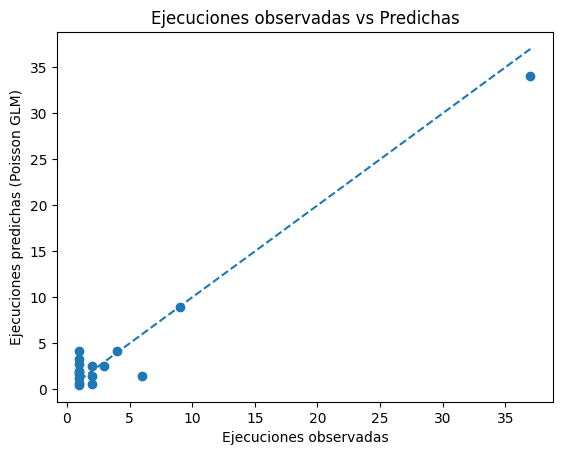

In [33]:

# Simple scatter of observed vs predicted (matplotlib only; one plot; no explicit colors)
plt.figure()
plt.scatter(comparison["observed"], comparison["predicted"])
plt.xlabel("Ejecuciones observadas")
plt.ylabel("Ejecuciones predichas (Poisson GLM)")
plt.title("Ejecuciones observadas vs Predichas")
plt.plot([comparison["observed"].min(), comparison["observed"].max()],
         [comparison["observed"].min(), comparison["observed"].max()],
         linestyle="--")
plt.show()
